# Meta-Embedded Clustering (MEC)

In [261]:
# Import the librairies
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

from pathlib import Path

import umap
from hdbscan.validity import validity_index
from hdbscan import HDBSCAN, all_points_membership_vectors

import torch
from torchvision import transforms
from torchvision.models import ResNet18_Weights, resnet18, VGG16_Weights, vgg16, DenseNet121_Weights, densenet121, AlexNet_Weights, alexnet
from torchvision.models.feature_extraction import create_feature_extractor

from sklearn.metrics.cluster import adjusted_mutual_info_score, adjusted_rand_score
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA, TruncatedSVD
from kneed import KneeLocator

from darksound.dataset import Darksound
from darksound.config import load_config

from darksound.networks.protonet import PrototypicalNetworks
from darksound.networks.matchnet import MatchingNetworks
from darksound.networks.relatnet import RelationNetworks

import warnings
warnings.filterwarnings("ignore")

In [245]:
class Relation(torch.nn.Module):
    def __init__(self, backbone):
        super(Relation, self).__init__()
        self.backbone = backbone
        self.additional_layers = torch.nn.Sequential(torch.nn.AdaptiveMaxPool2d((1, 1)),torch.nn.Flatten())
    def forward(self, x):
        x = self.backbone(x)
        embedding = list(x.values())[0]
        x = self.additional_layers(embedding)
        return x

def get_features(model, spectrogram, device, params):
    # Extract the features from the model
    if params['PARAMS_MODEL']['NETWORK'] == 'relation':
        relation_features = Relation(model.backbone).to(device)
        features = relation_features(spectrogram.to(device).unsqueeze(dim=0))
    else:
        features = model.backbone.forward(spectrogram.to(device).unsqueeze(dim=0)).squeeze(dim=0)
    # Detach and convert to numpy array 
    return features.detach().cpu().numpy()

def evaluation(features, true_labels, clusterer):
    # Remove noisy samples indexes from pseudo and true labels
    pseudo_labels = clusterer.labels_
    clustered = pseudo_labels >= 0
    # Compute evaluation metrics
    ari = adjusted_rand_score(true_labels[clustered], pseudo_labels[clustered])
    ami = adjusted_mutual_info_score(true_labels[clustered], pseudo_labels[clustered])
    # sometimes the validity index can't be computed
    try :
        dbcv, dbcv_per_cluster = validity_index(
                                    X=features.astype(np.float64),
                                    labels=pseudo_labels,
                                    metric='euclidean',
                                    per_cluster_scores=True)
    except:
        dbcv = np.nan  
        dbcv_per_cluster = [np.nan]
    return ari, ami, dbcv, dbcv_per_cluster 


def get_clusterer(features, n_components, method_reduc='PCA', method_cluster='DBSCAN', random_seed = 1979) :
    if method_reduc == 'PCA':
        # Linear reduction of dimensionality of the latent space 
        pca = PCA(n_components=n_components, random_state=random_seed)
        embedding = pca.fit_transform(features)
        # Determine the parameters for DBSCAN (Sander et al., 1998, Schubert et al., 2017)
        k = embedding.shape[1] * 2 -1
    elif method_reduc == 'TSVD':  
        # Linear reduction of dimensionality of the latent space
        embedding = TruncatedSVD(n_components=n_components, random_state=random_seed).fit_transform(features)
        # Determine the parameters for DBSCAN (Sander et al., 1998, Schubert et al., 2017)
        k = embedding.shape[1] * 2 -1
    elif method_reduc == 'UMAP':
        # Nonlinear reduction of dimensionality of the latent space
        embedding = umap.UMAP(densmap=True, n_components=n_components, n_jobs=-1, random_state=random_seed).fit_transform(features)
        # Determine the parameters for DBSCAN (Sander et al., 1998, Schubert et al., 2017)
        k = embedding.shape[1] * 2 -1
    else:
        embedding = features
        k = n_components * 2 -1

    # Calculate average distance between each point in the data set and its k-nearest neighbors (k corresponds to min_points).
    neighbors = NearestNeighbors(n_neighbors=k)
    neighbors_fit = neighbors.fit(embedding)
    distances, indices = neighbors_fit.kneighbors(embedding, n_neighbors=k)
    # Sort distance values by ascending value and plot
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1] 
    # Find the knee (curvature inflexion point)
    kneedle = KneeLocator(
        x = np.arange(0, len(distances), 1),
        y = distances,
        interp_method = "polynomial",
        curve = "convex",
        direction = "increasing")
    eps = float(kneedle.knee_y)  

    if method_cluster == 'HDBSCAN':
        # Perform HDBSCAN clustering from embedding array (min_cluster_size is equivalent to min_samples in DBSCAN)
        if eps == 0 :
            # clusterer = HDBSCAN(min_cluster_size=k, min_samples=k//2).fit(embedding)
            clusterer = HDBSCAN(min_cluster_size=k, min_samples=k//4).fit(embedding)
        else:
            # clusterer = HDBSCAN(min_cluster_size=k, min_samples=k//2, cluster_selection_epsilon=eps).fit(embedding)
            clusterer = HDBSCAN(min_cluster_size=k, min_samples=k//4).fit(embedding)
    elif method_cluster == 'DBSCAN':
        # Perform DBSCAN clustering from embedding array
        clusterer = DBSCAN(min_samples=k, eps=eps).fit(embedding)

    return clusterer, embedding


## Import config file and load CNN backbones

In [246]:
# path to the parent folder
parent_path = "..//darksound"

# Import config file and load parameters
params = load_config(f'{parent_path}//config.yaml')

# Name of the model
MODEL_NAME = 'prototypical-networks-5way-1shot-densenet'

# Flag to extract the features
EXTRACT_FEATURES = False

# options for the reduction and clustering methods
METHOD_REDUC = 'UMAP' 
METHOD_CLUSTER = 'DBSCAN'

# Set the seed for all random packages that could possibly be used
random_seed = params['RANDOM_SEED']
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------------------------------------------------
# LOAD THE CNN BACKBONE                
# -------------------------------------------------------------------------

# Use cuda if available for faster computations
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'The computations will be done on {device}')

# Load the backbones and the weights
if params['PARAMS_MODEL']['BACKBONE'] == 'resnet18':
    weights = ResNet18_Weights.IMAGENET1K_V1
    model = resnet18(weights=weights).to(device)
if params['PARAMS_MODEL']['BACKBONE'] == 'vgg16':
    weights = VGG16_Weights.IMAGENET1K_V1
    model = vgg16(weights=weights).to(device)
if params['PARAMS_MODEL']['BACKBONE'] == 'densenet':
    weights = DenseNet121_Weights.IMAGENET1K_V1
    model = densenet121(weights=weights).to(device)
if params['PARAMS_MODEL']['BACKBONE'] == 'alexnet':   
    weights = AlexNet_Weights.IMAGENET1K_V1
    model = alexnet(weights=weights).to(device)

print(f'The backbone {params["PARAMS_MODEL"]["BACKBONE"]} has been loaded')

bambird.extract_rois_full_sig
The computations will be done on cuda
The backbone densenet has been loaded


## Load the Darksound dataset and the meta-learning algorithms

In [247]:
# Load the Darksound dataset
test_set = Darksound(
                    root=parent_path,
                    split='test', 
                    hpss=params['PARAMS_MODEL']['HPSS'], 
                    remove_background=params['PARAMS_MODEL']['REMOVE_BG'], 
                    transform=transforms.Compose([weights.transforms()]),
                    n_classes=30,
                    download=True,
                    )
# Get the ground truth labels
true_labels = np.array(test_set.__getlabel__())

# Get features shape and flatten classifier or fully connected layers
if params['PARAMS_MODEL']['BACKBONE'] == 'resnet18':
    features = np.zeros(shape=(len(test_set), model.fc.in_features))
    model.fc = torch.nn.Flatten()
elif params['PARAMS_MODEL']['BACKBONE'] == 'vgg16':
    features = np.zeros(shape=(len(test_set), 512))
    # Reduce vector size and computation in the network
    model.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
    model.classifier = torch.nn.Flatten()
elif params['PARAMS_MODEL']['BACKBONE'] == 'densenet':
    features = np.zeros(shape=(len(test_set), model.classifier.in_features))
    model.classifier = torch.nn.Flatten()
elif params['PARAMS_MODEL']['BACKBONE'] == 'alexnet':
    features = np.zeros(shape=(len(test_set), 256))
    # Reduce vector size and computation in the network
    model.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
    model.classifier = torch.nn.Flatten()
    
# Load the meta-learning algorithms
if params['PARAMS_MODEL']['NETWORK'] == 'matching':
    model = MatchingNetworks(model, use_softmax=True).to(device)
if params['PARAMS_MODEL']['NETWORK'] == 'prototypical':
    model = PrototypicalNetworks(model, use_softmax=True).to(device)
if params['PARAMS_MODEL']['NETWORK'] == 'relation':
    if params['PARAMS_MODEL']['BACKBONE'] == 'resnet18':
        model = create_feature_extractor(model, return_nodes=['layer4.1.bn2']) 
    if params['PARAMS_MODEL']['BACKBONE'] == 'vgg16':
        model = create_feature_extractor(model, return_nodes=['features.30'])
    if params['PARAMS_MODEL']['BACKBONE'] == 'densenet':
        model = create_feature_extractor(model, return_nodes=['features.norm5'])
    if params['PARAMS_MODEL']['BACKBONE'] == 'alexnet':
        model = create_feature_extractor(model, return_nodes=['features.12'])  
    model = RelationNetworks(model, use_softmax=False).to(device)

bambird.extract_rois_full_sig
Files already downloaded and verified


## Extract features from the CNN backbone

In [248]:
if EXTRACT_FEATURES == True:

    # Load pretrained model fine-tuned on pseudo labeled set
    model.load_state_dict(
        torch.load(
            f'{parent_path}//embeddings//{MODEL_NAME}.pt', 
            map_location=device
            )
        ) 

    # Inference mode to extract features
    for i in tqdm(range(len(test_set)), desc='Extracting features'):
        # Extracting features from the model
        features[i] = get_features(model, test_set[i][0], device, params) 
    # Save the vector embeddings to disk
    np.save(f'{parent_path}//embeddings//features//{MODEL_NAME}-30classes.npy', features)

## Dimensionality reduction and clustering

In [249]:
features = np.load(f'{parent_path}//embeddings//features//{MODEL_NAME}-30classes.npy')
range_n_components = [10,15,20,25]

for n_components in range_n_components:

    clusterer, embedding = get_clusterer(
                                features=features, 
                                n_components= n_components, 
                                method_reduc=METHOD_REDUC, 
                                method_cluster=METHOD_CLUSTER, 
                                random_seed = random_seed)

    # Get the predicted labels and the number of clusters
    pseudo_labels = clusterer.labels_ 
    clusters = len(np.unique(pseudo_labels[pseudo_labels >= 0])) # remove noisy samples
    percentage = int(round(np.sum(pseudo_labels >= 0) / features.shape[0], 2) * 100)
    print(f'\nClustering {percentage}% of the data: Found {clusters} clusters with n_components={n_components}.')

    ari, ami, dbcv, dbcv_per_cluster = evaluation(embedding, true_labels, clusterer)
    print(f'ARI: {ari}\nAMI: {ami}\nDBCV: {dbcv}\nDBCV_avg: {np.mean(dbcv_per_cluster)}\n')


Clustering 53% of the data: Found 36 clusters with n_components=10.
ARI: 0.8047130742089781
AMI: 0.861460614450447
DBCV: 0.07277189780071229
DBCV_avg: 0.2865396020794036


Clustering 43% of the data: Found 24 clusters with n_components=15.
ARI: 0.8726345504313577
AMI: 0.904922151498595
DBCV: 0.2548730539234031
DBCV_avg: 0.562179871799439


Clustering 37% of the data: Found 18 clusters with n_components=20.
ARI: 0.8872620281584215
AMI: 0.922493341629999
DBCV: 0.2633127769580753
DBCV_avg: 0.6953401088371067


Clustering 30% of the data: Found 14 clusters with n_components=25.
ARI: 0.8932636702030655
AMI: 0.9376952829201781
DBCV: 0.24335240958677495
DBCV_avg: 0.7683566514062737



In [250]:
#--------------------------------------------------------------------------
# SET THE NUMBER OF COMPONENTS FOR THE REDUCTION
#--------------------------------------------------------------------------
N_COMPONENTS = 15

## Plot the vector embeddings in two dimensions

Create a random colormap

Number of labels: 50


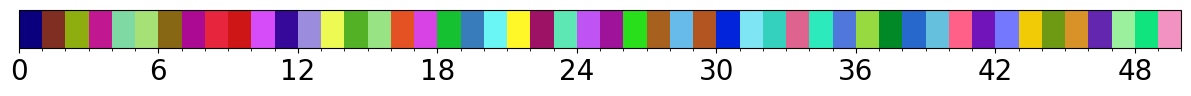

In [251]:
def rand_cmap(nlabels, first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map based on HLS
    randHLScolors = [(i / 360.,
                    (20 + 50 * np.random.rand() +  np.random.rand()*10) / 100.,
                    (50 + 50 * np.random.rand() +  np.random.rand()*10) / 100.) for i in np.arange(0., 360., 360. / nlabels)]

    # Convert HLS list to RGB
    randRGBcolors = []
    for HLScolor in randHLScolors:
        randRGBcolors.append(colorsys.hls_to_rgb(HLScolor[0], HLScolor[1], HLScolor[2]))

    if first_color_black:
        randRGBcolors[0] = [0, 0, 0]

    if last_color_black:
        randRGBcolors[-1] = [0, 0, 0]

    random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # shuffle a colormap matplotlib object
    indices = np.linspace(0, 1, nlabels)
    np.random.shuffle(indices)
    colors = random_colormap(indices)

    random_colormap = LinearSegmentedColormap.from_list('new_map', colors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

def plot_embedding(features_path, n_components=10, method_reduc='UMAP', method_cluster='DBSCAN', random_seed=1979):
    features = np.load(features_path)
    clusterer, embedding = get_clusterer(
                        features=features, 
                        n_components= n_components, 
                        method_reduc=method_reduc, 
                        method_cluster=method_cluster, 
                        random_seed = random_seed)
    # Get the predicted labels and the number of clusters
    labels = clusterer.labels_ 
    # Reduce dimensionality
    reduced_embedding = umap.UMAP(n_jobs=-1, n_components=2, random_state=random_seed).fit_transform(features)
    
    return labels, reduced_embedding 

new_cmap = rand_cmap(50, first_color_black=False, last_color_black=False, verbose=True)

Load the vector embeddings and plot

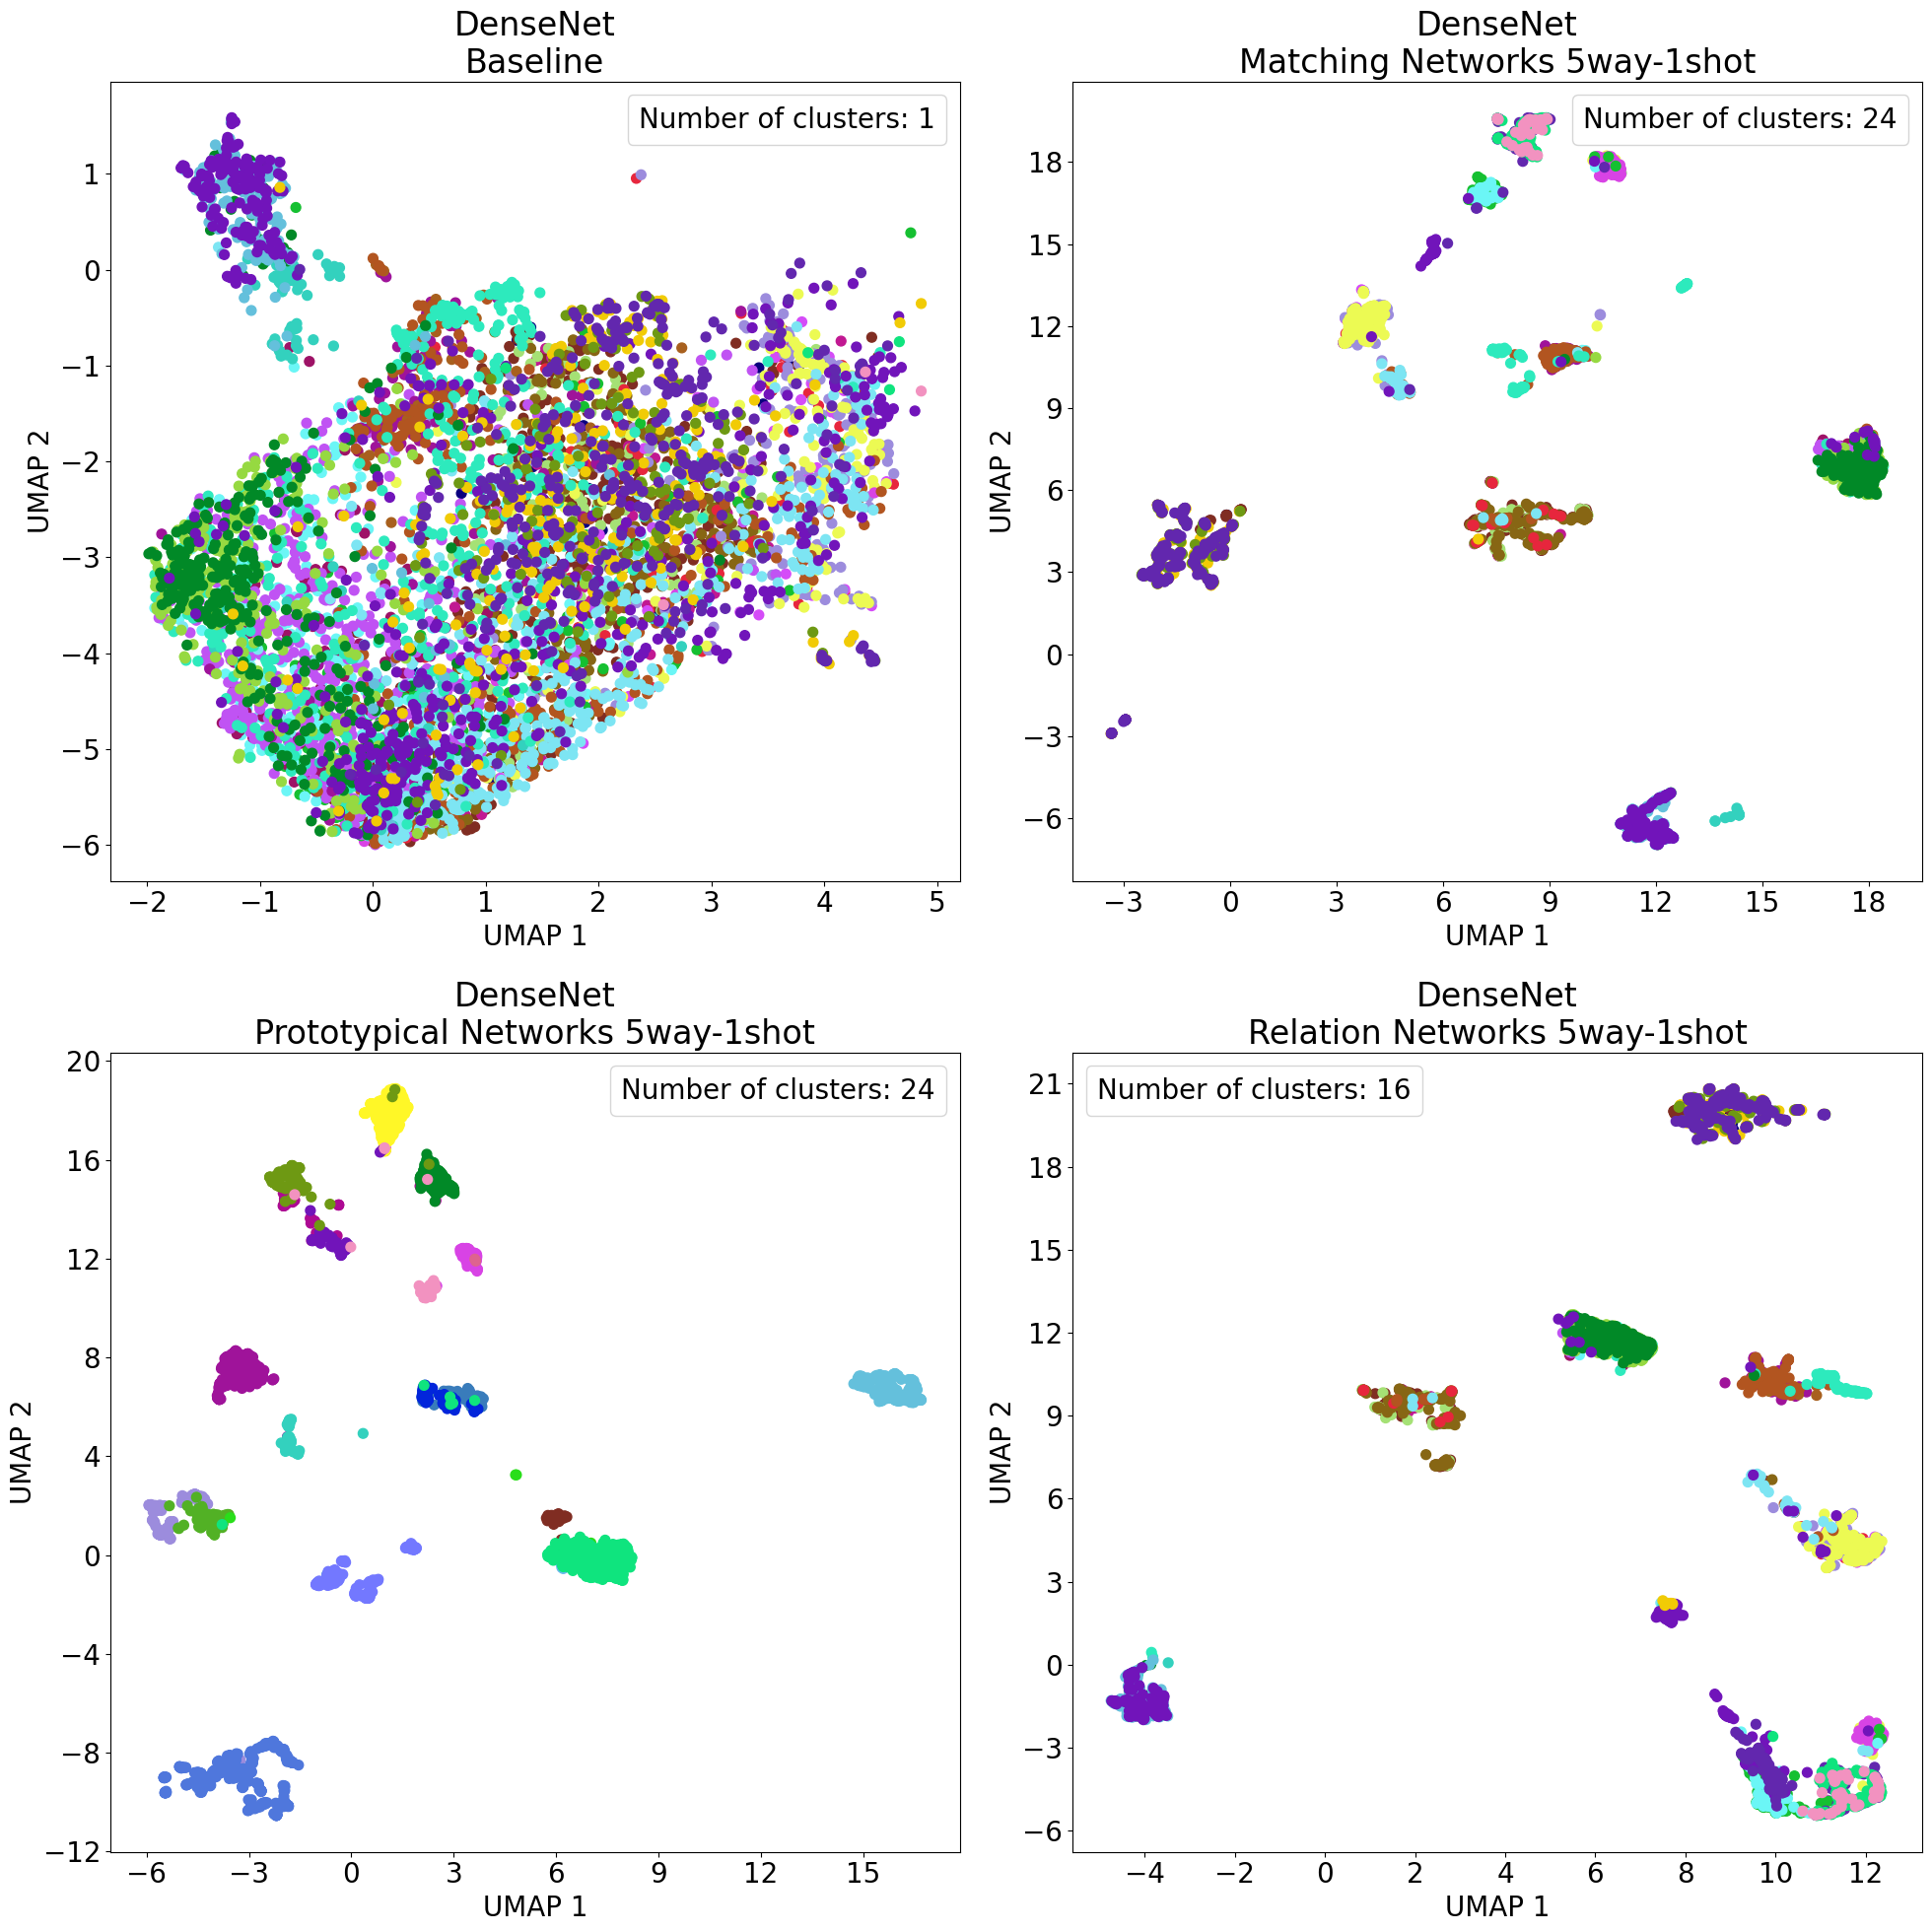

In [252]:
matplotlib.rcParams.update({'font.size': 20})
from matplotlib.ticker import MaxNLocator

# Load vector embeddings
baseline_labels, baseline_plot = plot_embedding(
                            f'{parent_path}//embeddings//features//baseline-densenet-30classes.npy', 
                            n_components=N_COMPONENTS,
                            method_reduc=METHOD_REDUC,
                            method_cluster=METHOD_CLUSTER,
                            random_seed=random_seed)
mn_labels, mn_plot = plot_embedding(
                            f'{parent_path}//embeddings//features//matching-networks-5way-5shot-densenet-30classes.npy',
                            n_components=N_COMPONENTS,
                            method_reduc=METHOD_REDUC,
                            method_cluster=METHOD_CLUSTER,
                            random_seed=random_seed)
pn_labels, pn_plot = plot_embedding(
                            f'{parent_path}//embeddings//features//prototypical-networks-5way-1shot-densenet-30classes.npy',
                            n_components=N_COMPONENTS,
                            method_reduc=METHOD_REDUC,
                            method_cluster=METHOD_CLUSTER,
                            random_seed=random_seed)
rn_labels, rn_plot = plot_embedding(
                            f'{parent_path}//embeddings//features//relation-networks-5way-1shot-densenet-30classes.npy',
                            n_components=N_COMPONENTS,
                            method_reduc=METHOD_REDUC,
                            method_cluster=METHOD_CLUSTER,
                            random_seed=random_seed)
                            
# Create scatter plots
fig = plt.figure(figsize=(20, 20))
marker_size = 50

ax = fig.add_subplot(2, 2, 1)
ax.set_title('DenseNet\nBaseline')
ax.scatter(baseline_plot[baseline_labels >= 0].T[0], baseline_plot[baseline_labels >= 0].T[1], 
        s=marker_size, c=true_labels[baseline_labels >= 0],
        cmap=new_cmap, label=f'Number of clusters: {len(np.unique(baseline_labels))-1}') 
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True)
for item in leg.legendHandles:
    item.set_visible(False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax = fig.add_subplot(2, 2, 2)
ax.set_title('DenseNet\nMatching Networks 5way-1shot')
ax.scatter(mn_plot[mn_labels >= 0].T[0], mn_plot[mn_labels >= 0].T[1], 
        s=marker_size, c=true_labels[mn_labels >= 0],
        cmap=new_cmap, label=f'Number of clusters: {len(np.unique(mn_labels))-1}')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True)
for item in leg.legendHandles:
    item.set_visible(False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax = fig.add_subplot(2, 2, 3)
ax.set_title('DenseNet\nPrototypical Networks 5way-1shot')
ax.scatter(pn_plot[pn_labels >= 0].T[0], pn_plot[pn_labels >= 0].T[1], 
        s=marker_size, c=true_labels[pn_labels >= 0],
        cmap=new_cmap, label=f'Number of clusters: {len(np.unique(pn_labels))-1}') 
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True)
for item in leg.legendHandles:
    item.set_visible(False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

ax = fig.add_subplot(2, 2, 4)
ax.set_title('DenseNet\nRelation Networks 5way-1shot')
ax.scatter(rn_plot[rn_labels >= 0].T[0], rn_plot[rn_labels >= 0].T[1],
        s=marker_size, c=true_labels[rn_labels >= 0],
        cmap=new_cmap, label=f'Number of clusters: {len(np.unique(rn_labels))-1}')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True)
for item in leg.legendHandles:
    item.set_visible(False)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
# plt.savefig('plot.jpg', dpi=300);

## Explore the clusters

MEC is able to find clusters of sounds with good scores (Metric ARI and AMI). The number of clusters is close to expected number. However, a lot of ROIs does not belong to any cluster (ie noise) and the number of clusters as well as the metrics do not tell us :
* if all species belong to at least one cluster
* how many species belong to each cluster

In the following, we will :
* calculate and display the metrics
* show the species that belong to each cluster as well as the number of songs of each species
* find the species that do not belong to any clusters (ie all the bird songs are labeled as noise)
* find the most representative species for each cluster (ie the species with the highest number of bird songs in the cluster)
* find the species that are not the most representative species (ie the species that do not have the majority of bird songs in any clusters)

In [253]:
# load the features
features = np.load(f'{parent_path}//embeddings//features//{MODEL_NAME}-30classes.npy')

# Find the clusters
clusterer, embedding = get_clusterer(
                    features=features, 
                    n_components=N_COMPONENTS, 
                    method_reduc=METHOD_REDUC, 
                    method_cluster=METHOD_CLUSTER, 
                    random_seed = random_seed)

# Get the predicted labels and the number of clusters
pseudo_labels = clusterer.labels_ 
clusters = len(np.unique(pseudo_labels[pseudo_labels >= 0])) # remove noisy samples
percentage = int(round(np.sum(pseudo_labels >= 0) / features.shape[0], 2) * 100)
print(f'\nClustering {percentage}% of the data: Found {clusters} clusters with n_components={N_COMPONENTS}.')

ari, ami, dbcv, dbcv_per_cluster = evaluation(embedding, true_labels, clusterer)
print(f'ARI: {ari}\nAMI: {ami}\nDBCV: {dbcv}\nDBCV_avg: {np.mean(dbcv_per_cluster)}\n')


Clustering 43% of the data: Found 24 clusters with n_components=15.
ARI: 0.8726345504313577
AMI: 0.904922151498595
DBCV: 0.2548730539234031
DBCV_avg: 0.562179871799439



In [254]:
# Get the list of tuples (file, label) for each species
species_files = test_set._flat_species_files
# Get the list of species
species = test_set._species
# Create a dictionary with the label as keys and the species as values
species_dict = {label: species for label, species in zip(np.unique(true_labels), species)}

#
print("Species found in the dataset:")
species_dict

Species found in the dataset:


{0: 'Chordeiles acutipennis_Lesser Nighthawk',
 1: 'Crypturellus soui_Little Tinamou',
 2: 'Nyctibius leucopterus_White-winged Potoo',
 3: 'Nyctibius griseus_Common Potoo',
 4: 'Strix huhula_Black-banded Owl',
 5: 'Hydropsalis cayennensis_White-tailed Nightjar',
 6: 'Hydropsalis climacocerca_Ladder-tailed Nightjar',
 7: 'Nyctiprogne leucopyga_Band-tailed Nighthawk',
 8: 'Lurocalis semitorquatus_Short-tailed Nighthawk',
 9: 'Chordeiles nacunda_Nacunda Nighthawk',
 10: 'Megascops watsonii_Tawny-bellied Screech Owl',
 11: 'Glaucidium hardyi_Amazonian Pygmy Owl',
 12: 'Lophostrix cristata_Crested Owl',
 13: 'Nyctipolus nigrescens_Blackish Nightjar',
 14: 'Micrastur semitorquatus_Collared Forest Falcon',
 15: 'Crypturellus variegatus_Variegated Tinamou',
 16: 'Crypturellus brevirostris_Rusty Tinamou',
 17: 'Tinamus major_Great Tinamou',
 18: 'Micrastur gilvicollis_Lined Forest Falcon',
 19: 'Megascops roraimae_Foothill Screech Owl',
 20: 'Nyctidromus albicollis_Pauraque',
 21: 'Pulsatrix pe

In [255]:
# For each cluster, print the species with the number of points per species
for pseudo_label_id in np.unique(pseudo_labels) :
    if pseudo_label_id != -1 :
        print(f'Cluster {pseudo_label_id} :')
        for true_label_id in np.unique(true_labels) :
            if np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id)) > 0:
                print(f'    {species_dict[true_label_id]} : {np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id))}')

Cluster 0 :
    Chordeiles acutipennis_Lesser Nighthawk : 9
    Megascops watsonii_Tawny-bellied Screech Owl : 98
    Megascops roraimae_Foothill Screech Owl : 2
Cluster 1 :
    Crypturellus soui_Little Tinamou : 25
    Crypturellus variegatus_Variegated Tinamou : 9
    Crypturellus brevirostris_Rusty Tinamou : 14
    Tinamus major_Great Tinamou : 2
    Crypturellus cinereus_Cinereous Tinamou : 488
Cluster 2 :
    Crypturellus soui_Little Tinamou : 33
Cluster 3 :
    Nyctibius leucopterus_White-winged Potoo : 3
    Glaucidium hardyi_Amazonian Pygmy Owl : 11
    Tinamus major_Great Tinamou : 40
    Micrastur gilvicollis_Lined Forest Falcon : 1
    Crypturellus cinereus_Cinereous Tinamou : 1
Cluster 4 :
    Strix huhula_Black-banded Owl : 48
    Strix virgata_Mottled Owl : 2
    Nyctibius grandis_Great Potoo : 1
Cluster 5 :
    Strix huhula_Black-banded Owl : 22
    Micrastur semitorquatus_Collared Forest Falcon : 1
    Nyctibius aethereus_Long-tailed Potoo : 111
    Strix virgata_Mottle

In [256]:
# Find the label in true_labels that are always equal to -1 in pseudo_labels
missing_species_any_cluster = []
for true_label_id in np.unique(true_labels) :
    if np.sum((pseudo_labels == -1) & (true_labels == true_label_id)) == np.sum((true_labels == true_label_id)) :
        missing_species_any_cluster.append(true_label_id)

print(f'{len(missing_species_any_cluster)} / {len(species_dict)} species are not present in any cluster.')

print("The list is:")
for nn in missing_species_any_cluster :
    print(f'    {species_dict[nn]}')

6 / 30 species are not present in any cluster.
The list is:
    Nyctibius griseus_Common Potoo
    Hydropsalis cayennensis_White-tailed Nightjar
    Hydropsalis climacocerca_Ladder-tailed Nightjar
    Chordeiles nacunda_Nacunda Nighthawk
    Micrastur mirandollei_Slaty-backed Forest Falcon
    Nyctibius bracteatus_Rufous Potoo


In [257]:
# list of labels corresponding to the most represented species in each cluster
label_to_cluster = []

# For each cluster, select the species with the most points and compute the percentage of points in the cluster
for pseudo_label_id in np.unique(pseudo_labels) :
    if pseudo_label_id != -1 :
        label_to_cluster += [np.unique(true_labels)[np.argmax([np.sum((pseudo_labels == pseudo_label_id) & (true_labels == true_label_id)) for true_label_id in np.unique(true_labels)])]]
        print(f'Cluster {pseudo_label_id} : {species_dict[label_to_cluster[-1]]} : {np.round(np.sum((pseudo_labels == pseudo_label_id) & (true_labels == label_to_cluster[-1])) / np.sum(pseudo_labels == pseudo_label_id) * 100).astype("int")}%')

Cluster 0 : Megascops watsonii_Tawny-bellied Screech Owl : 90%
Cluster 1 : Crypturellus cinereus_Cinereous Tinamou : 91%
Cluster 2 : Crypturellus soui_Little Tinamou : 100%
Cluster 3 : Tinamus major_Great Tinamou : 71%
Cluster 4 : Strix huhula_Black-banded Owl : 94%
Cluster 5 : Nyctibius aethereus_Long-tailed Potoo : 82%
Cluster 6 : Pulsatrix perspicillata_Spectacled Owl : 98%
Cluster 7 : Nyctiprogne leucopyga_Band-tailed Nighthawk : 97%
Cluster 8 : Nyctiprogne leucopyga_Band-tailed Nighthawk : 95%
Cluster 9 : Nyctidromus albicollis_Pauraque : 97%
Cluster 10 : Lurocalis semitorquatus_Short-tailed Nighthawk : 98%
Cluster 11 : Glaucidium hardyi_Amazonian Pygmy Owl : 91%
Cluster 12 : Lophostrix cristata_Crested Owl : 97%
Cluster 13 : Micrastur semitorquatus_Collared Forest Falcon : 100%
Cluster 14 : Micrastur gilvicollis_Lined Forest Falcon : 96%
Cluster 15 : Tinamus major_Great Tinamou : 67%
Cluster 16 : Micrastur ruficollis_Barred Forest Falcon : 95%
Cluster 17 : Nyctidromus albicollis_

In [258]:
# list of species that are not the most represented in any cluster
missing_species_as_main_cluster = np.setdiff1d(np.unique(true_labels), label_to_cluster)

print(f'{len(missing_species_as_main_cluster)} / {len(species_dict)} species are not representing by a cluster.')

print("The list is:")
for label in missing_species_as_main_cluster :
    print(f'    {species_dict[label]}')

12 / 30 species are not representing by a cluster.
The list is:
    Chordeiles acutipennis_Lesser Nighthawk
    Nyctibius leucopterus_White-winged Potoo
    Nyctibius griseus_Common Potoo
    Hydropsalis cayennensis_White-tailed Nightjar
    Hydropsalis climacocerca_Ladder-tailed Nightjar
    Chordeiles nacunda_Nacunda Nighthawk
    Nyctipolus nigrescens_Blackish Nightjar
    Crypturellus variegatus_Variegated Tinamou
    Crypturellus brevirostris_Rusty Tinamou
    Megascops roraimae_Foothill Screech Owl
    Micrastur mirandollei_Slaty-backed Forest Falcon
    Nyctibius bracteatus_Rufous Potoo


In [259]:
# for each species in the list missing_species_as_main_cluster, find the clusters where they are present
# and the percentage of points that they represent from the total number of points of the species
for label in missing_species_as_main_cluster :
    print(f'{species_dict[label]} :')
    for pseudo_label_id in np.unique(pseudo_labels) :
        if pseudo_label_id != -1 :
            if np.sum((pseudo_labels == pseudo_label_id) & (true_labels == label)) > 0:
                print(f'    Cluster {pseudo_label_id} : {np.round(np.sum((pseudo_labels == pseudo_label_id) & (true_labels == label)) / np.sum(true_labels == label) * 100).astype("int")}%')
    # print the sum of the percentage of points that the species represent in the clusters
    print(f'    Total : {np.round(np.sum([np.sum((pseudo_labels == pseudo_label_id) & (true_labels == label)) / np.sum(true_labels == label) * 100 for pseudo_label_id in np.unique(pseudo_labels) if pseudo_label_id != -1])).astype("int")}%')


Chordeiles acutipennis_Lesser Nighthawk :
    Cluster 0 : 29%
    Total : 29%
Nyctibius leucopterus_White-winged Potoo :
    Cluster 3 : 5%
    Cluster 11 : 2%
    Cluster 15 : 2%
    Total : 8%
Nyctibius griseus_Common Potoo :
    Total : 0%
Hydropsalis cayennensis_White-tailed Nightjar :
    Total : 0%
Hydropsalis climacocerca_Ladder-tailed Nightjar :
    Total : 0%
Chordeiles nacunda_Nacunda Nighthawk :
    Total : 0%
Nyctipolus nigrescens_Blackish Nightjar :
    Cluster 17 : 1%
    Total : 1%
Crypturellus variegatus_Variegated Tinamou :
    Cluster 1 : 7%
    Cluster 10 : 1%
    Total : 8%
Crypturellus brevirostris_Rusty Tinamou :
    Cluster 1 : 34%
    Total : 34%
Megascops roraimae_Foothill Screech Owl :
    Cluster 0 : 2%
    Total : 2%
Micrastur mirandollei_Slaty-backed Forest Falcon :
    Total : 0%
Nyctibius bracteatus_Rufous Potoo :
    Total : 0%
